In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv2D, GlobalMaxPooling1D, GlobalMaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

2025-08-31 18:54:54.250931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756666494.439723      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756666494.496231      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [3]:
import pandas as pd

ratings_df = pd.read_csv('/kaggle/input/movie-lens-small-latest-dataset/ratings.csv')
movies_df = pd.read_csv('/kaggle/input/movie-lens-small-latest-dataset/movies.csv')

df = ratings_df.merge(movies_df[['movieId', 'genres']], on='movieId')

In [4]:
# Extract all unique genres
all_genres_lists = df['genres'].str.split('|').tolist()
all_genres = set()
for genre_list in all_genres_lists:
    all_genres.update(genre_list)

# Create genre vocabulary
genre_vocab = sorted(list(all_genres))
print(f"Found genres: {len(genre_vocab)}")
print(f"Genres: {genre_vocab}")

# Map genres to indices
genre2idx = {genre: idx for idx, genre in enumerate(genre_vocab)}
num_genres = len(genre_vocab)

def encode_genres(genres_str):
    """Encode genres as a one-hot vector"""
    if pd.isna(genres_str):
        return np.zeros(num_genres, dtype=np.float32)
    
    genre_vector = np.zeros(num_genres, dtype=np.float32)
    genres = genres_str.split('|')
    for genre in genres:
        if genre in genre2idx:
            genre_vector[genre2idx[genre]] = 1.0
    return genre_vector

# Encode all movie genres
genre_vectors = np.array([encode_genres(genres) for genres in df['genres']])

Found genres: 20
Genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [5]:
# Compute each user's taste profile based on the genres of the movies they rated highly
user_profiles = {}
user_genre_interactions = {}

for _, row in df.iterrows():
    user_id = row['userId']
    rating = row['rating']
    genres_str = row['genres']
    
    if user_id not in user_profiles:
        user_profiles[user_id] = np.zeros(num_genres, dtype=np.float32)
        user_genre_interactions[user_id] = []
    
    # Create a user-genre interaction vector weighted by the rating
    genre_vector = encode_genres(genres_str)
    weighted_genres = genre_vector * rating  
    
    user_profiles[user_id] += weighted_genres
    user_genre_interactions[user_id].append(weighted_genres)

# Normalize user profiles
for user_id in user_profiles:
    if np.sum(user_profiles[user_id]) > 0:
        user_profiles[user_id] = user_profiles[user_id] / np.sum(user_profiles[user_id])

print(f"Profiles created for {len(user_profiles)} users")

Profiles created for 610 users


In [6]:
# USER-MOVIE INTERACTION MATRICES FOR CNN

def create_user_movie_matrix(user_id, movie_genres):
    """
    Create a user-movie interaction matrix for the CNN.
    Combines the user profile with the movie genres.
    """
    user_profile = user_profiles.get(user_id, np.zeros(num_genres))
    
    # Create a 2D matrix (user_profile, movie_genres, interaction)
    interaction_matrix = np.zeros((3, num_genres), dtype=np.float32)
    
    # Row 1: User profile (average tastes)
    interaction_matrix[0, :] = user_profile
    
    # Row 2: Movie genres
    interaction_matrix[1, :] = movie_genres
    
    # Row 3: Interaction (element-wise product)
    interaction_matrix[2, :] = user_profile * movie_genres
    
    return interaction_matrix

# Prepare CNN input data
X_matrices = []
y_ratings = []

for _, row in df.iterrows():
    user_id = row['userId']
    movie_genres = encode_genres(row['genres'])
    rating = row['rating']
    
    interaction_matrix = create_user_movie_matrix(user_id, movie_genres)
    
    X_matrices.append(interaction_matrix)
    y_ratings.append(rating)

X_matrices = np.array(X_matrices)
y_ratings = np.array(y_ratings, dtype=np.float32)

print(f"Shape of input matrices: {X_matrices.shape}")
print(f"Shape of ratings: {y_ratings.shape}")

Shape of input matrices: (100836, 3, 20)
Shape of ratings: (100836,)


In [7]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_matrices, y_ratings,
    test_size=0.2,
    random_state=42,
    stratify=y_ratings  # Preserve rating distribution
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (80668, 3, 20)
Validation set shape: (20168, 3, 20)


In [8]:
CONV_FILTERS_1 = 64
CONV_FILTERS_2 = 32
CONV_KERNEL_SIZE = 3
DENSE_UNITS = 128
DROPOUT_RATE = 0.3

# 2D CNN model to process interaction matrices
model = Sequential([
    
    Input(shape=(3, num_genres)),
    
    Reshape((3, num_genres, 1)),
    
    # First 2D convolutional layer
    Conv2D(filters=CONV_FILTERS_1, kernel_size=(2, 3), activation='relu', padding='same'),
    Dropout(DROPOUT_RATE),
    
    # Second 2D convolutional layer
    Conv2D(filters=CONV_FILTERS_2, kernel_size=(2, 3), activation='relu', padding='same'),
    Dropout(DROPOUT_RATE),
    
    # Global Max Pooling to extract the most important features
    GlobalMaxPooling2D(),
    
    # Dense layers
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(DROPOUT_RATE),
    
    Dense(DENSE_UNITS//2, activation='relu'),
    Dropout(DROPOUT_RATE),
    
    Dense(DENSE_UNITS//4, activation='relu'),
    Dropout(DROPOUT_RATE),
    
    # Output
    Dense(1, activation='linear')
])

# Compilation
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

I0000 00:00:1756666518.037295      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756666518.038019      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 3, 20, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 3, 20, 64)           │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 20, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 20, 32)           │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 20, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,361 (106.88 KB)

 Trainable params: 27,361 (106.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# training
history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1756666522.522257      97 service.cc:148] XLA service 0x7a3ab000ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756666522.522878      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756666522.522897      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756666522.890895      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 42/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8458 - mae: 2.6544 

I0000 00:00:1756666527.632535      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.8354 - mae: 1.5538 - val_loss: 2.0520 - val_mae: 1.2396 - learning_rate: 0.0010
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5911 - mae: 1.0123 - val_loss: 1.4433 - val_mae: 1.0009 - learning_rate: 0.0010
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5016 - mae: 0.9824 - val_loss: 1.2146 - val_mae: 0.9044 - learning_rate: 0.0010
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4469 - mae: 0.9647 - val_loss: 1.1263 - val_mae: 0.8716 - learning_rate: 0.0010
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4035 - mae: 0.9480 - val_loss: 1.1051 - val_mae: 0.8607 - learning_rate: 0.0010
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3647 - mae: 0.9363 - val_loss: 1.0794 - val_mae: 0.8453 - learning_rate: 0.0010
Epoch 7/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3100 - mae: 0.9150 - val_loss: 1.0766 - val_mae: 0.8442 - learning_rate: 0.0010
Epoch 8/1


Final results:
Train - Loss: 0.9907, MAE: 0.7936
Validation - Loss: 0.9916, MAE: 0.7926
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.9958
MAE: 0.7926


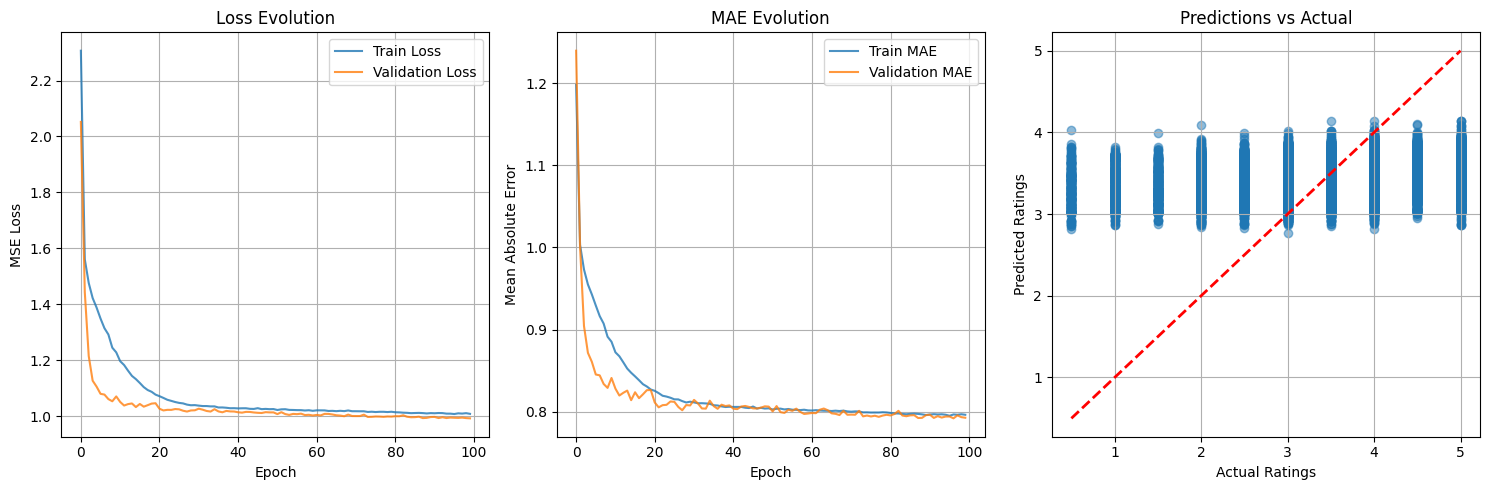

In [10]:
# Evaluation
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

print(f"\nFinal results:")
print(f"Train - Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")

# Predictions for analysis
y_pred = model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE', alpha=0.8)
plt.plot(history.history['val_mae'], label='Validation MAE', alpha=0.8)
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predictions vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()